In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# general-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Scikit-Learn
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,precision_score,recall_score,auc, accuracy_score,f1_score


# Constructs a new estimator with the same parameters.
# Clone does a deep copy of the model in an estimator 
# without actually copying attached data. It yields a 
# new estimator with the same parameters that has not 
# been fit on any data.
from sklearn import clone 

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,BaggingClassifier)
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# libraries needed to plot decision trees
import io
from scipy import misc
from scipy.stats import randint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def build_df():
    """
    Once the files have been unzipped, let's build some dataframes from the three types of data we have:
    IE phone calls, contacts, and text messages

    :return:
    Three pandas.DataFrames [calls, contacts, sms]
    """

    # Set our top-level file path to find all the data
    origin_root = "../data/user_logs/"

    # Create multiple lists so we can concat later
    call_list = list()
    contact_list = list()
    sms_list = list()

    # TODO: research about writing on the fly when unzipping the files
    for root, dirs, files in os.walk(origin_root):
        for file in files:
            if file.endswith("collated_call_log.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                call_list.append(temp_df)
            elif file.endswith("collated_contact_list.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                contact_list.append(temp_df)
            elif file.endswith("collated_sms_log.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                sms_list.append(temp_df)

    # Combine the respective data in their own groupings
    call_df = pd.concat(call_list, axis=0)
    contact_df = pd.concat(contact_list, axis=0)
    sms_df = pd.concat(sms_list, axis=0)

    return call_df, contact_df, sms_df

call_df, contact_df, sms_df = build_df()

loan_df = pd.read_csv("../data/user_logs/user_status.csv", parse_dates=['disbursement_date'])
loan_df['user_id'] = "user-" + loan_df['user_id'].apply(str)
dummy_loans = pd.get_dummies(loan_df['status'])
loan_df = pd.concat([loan_df, dummy_loans], axis=1)

# Create High level features

In [3]:
dates_loans = loan_df.copy()
dates_loans = dates_loans.set_index('disbursement_date').groupby(pd.Grouper(freq='D')).sum().dropna()
dates_loans['total_loans'] = dates_loans['defaulted'] + dates_loans['repaid']
dates_loans['prop_default'] = dates_loans['defaulted'] / dates_loans['total_loans']

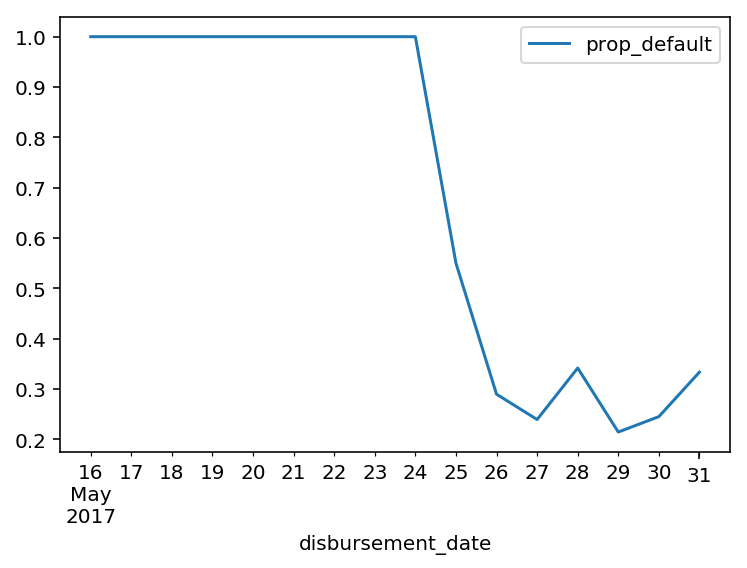

In [4]:
dates_loans.plot(x=dates_loans.index, y='prop_default')

In [5]:
loan_df['day_of_month'] = loan_df.disbursement_date.dt.day
loan_df['weekday'] = loan_df.disbursement_date.dt.dayofweek

In [6]:
vars_df_sms = sms_df.groupby('user_id')[['thread_id', 'message_body', 'sms_address']].nunique().reset_index()
vars_df_call = call_df.groupby('user_id')[['country_iso', 'geocoded_location', 'device_id']].nunique().reset_index()
vars_df_contact = contact_df.groupby('user_id')[['display_name', 'photo_id']].nunique().reset_index()

baseline_df = vars_df_sms.merge(vars_df_call).merge(vars_df_contact).merge(loan_df).set_index('user_id')

del baseline_df['status']
del baseline_df['defaulted']
del baseline_df['disbursement_date']

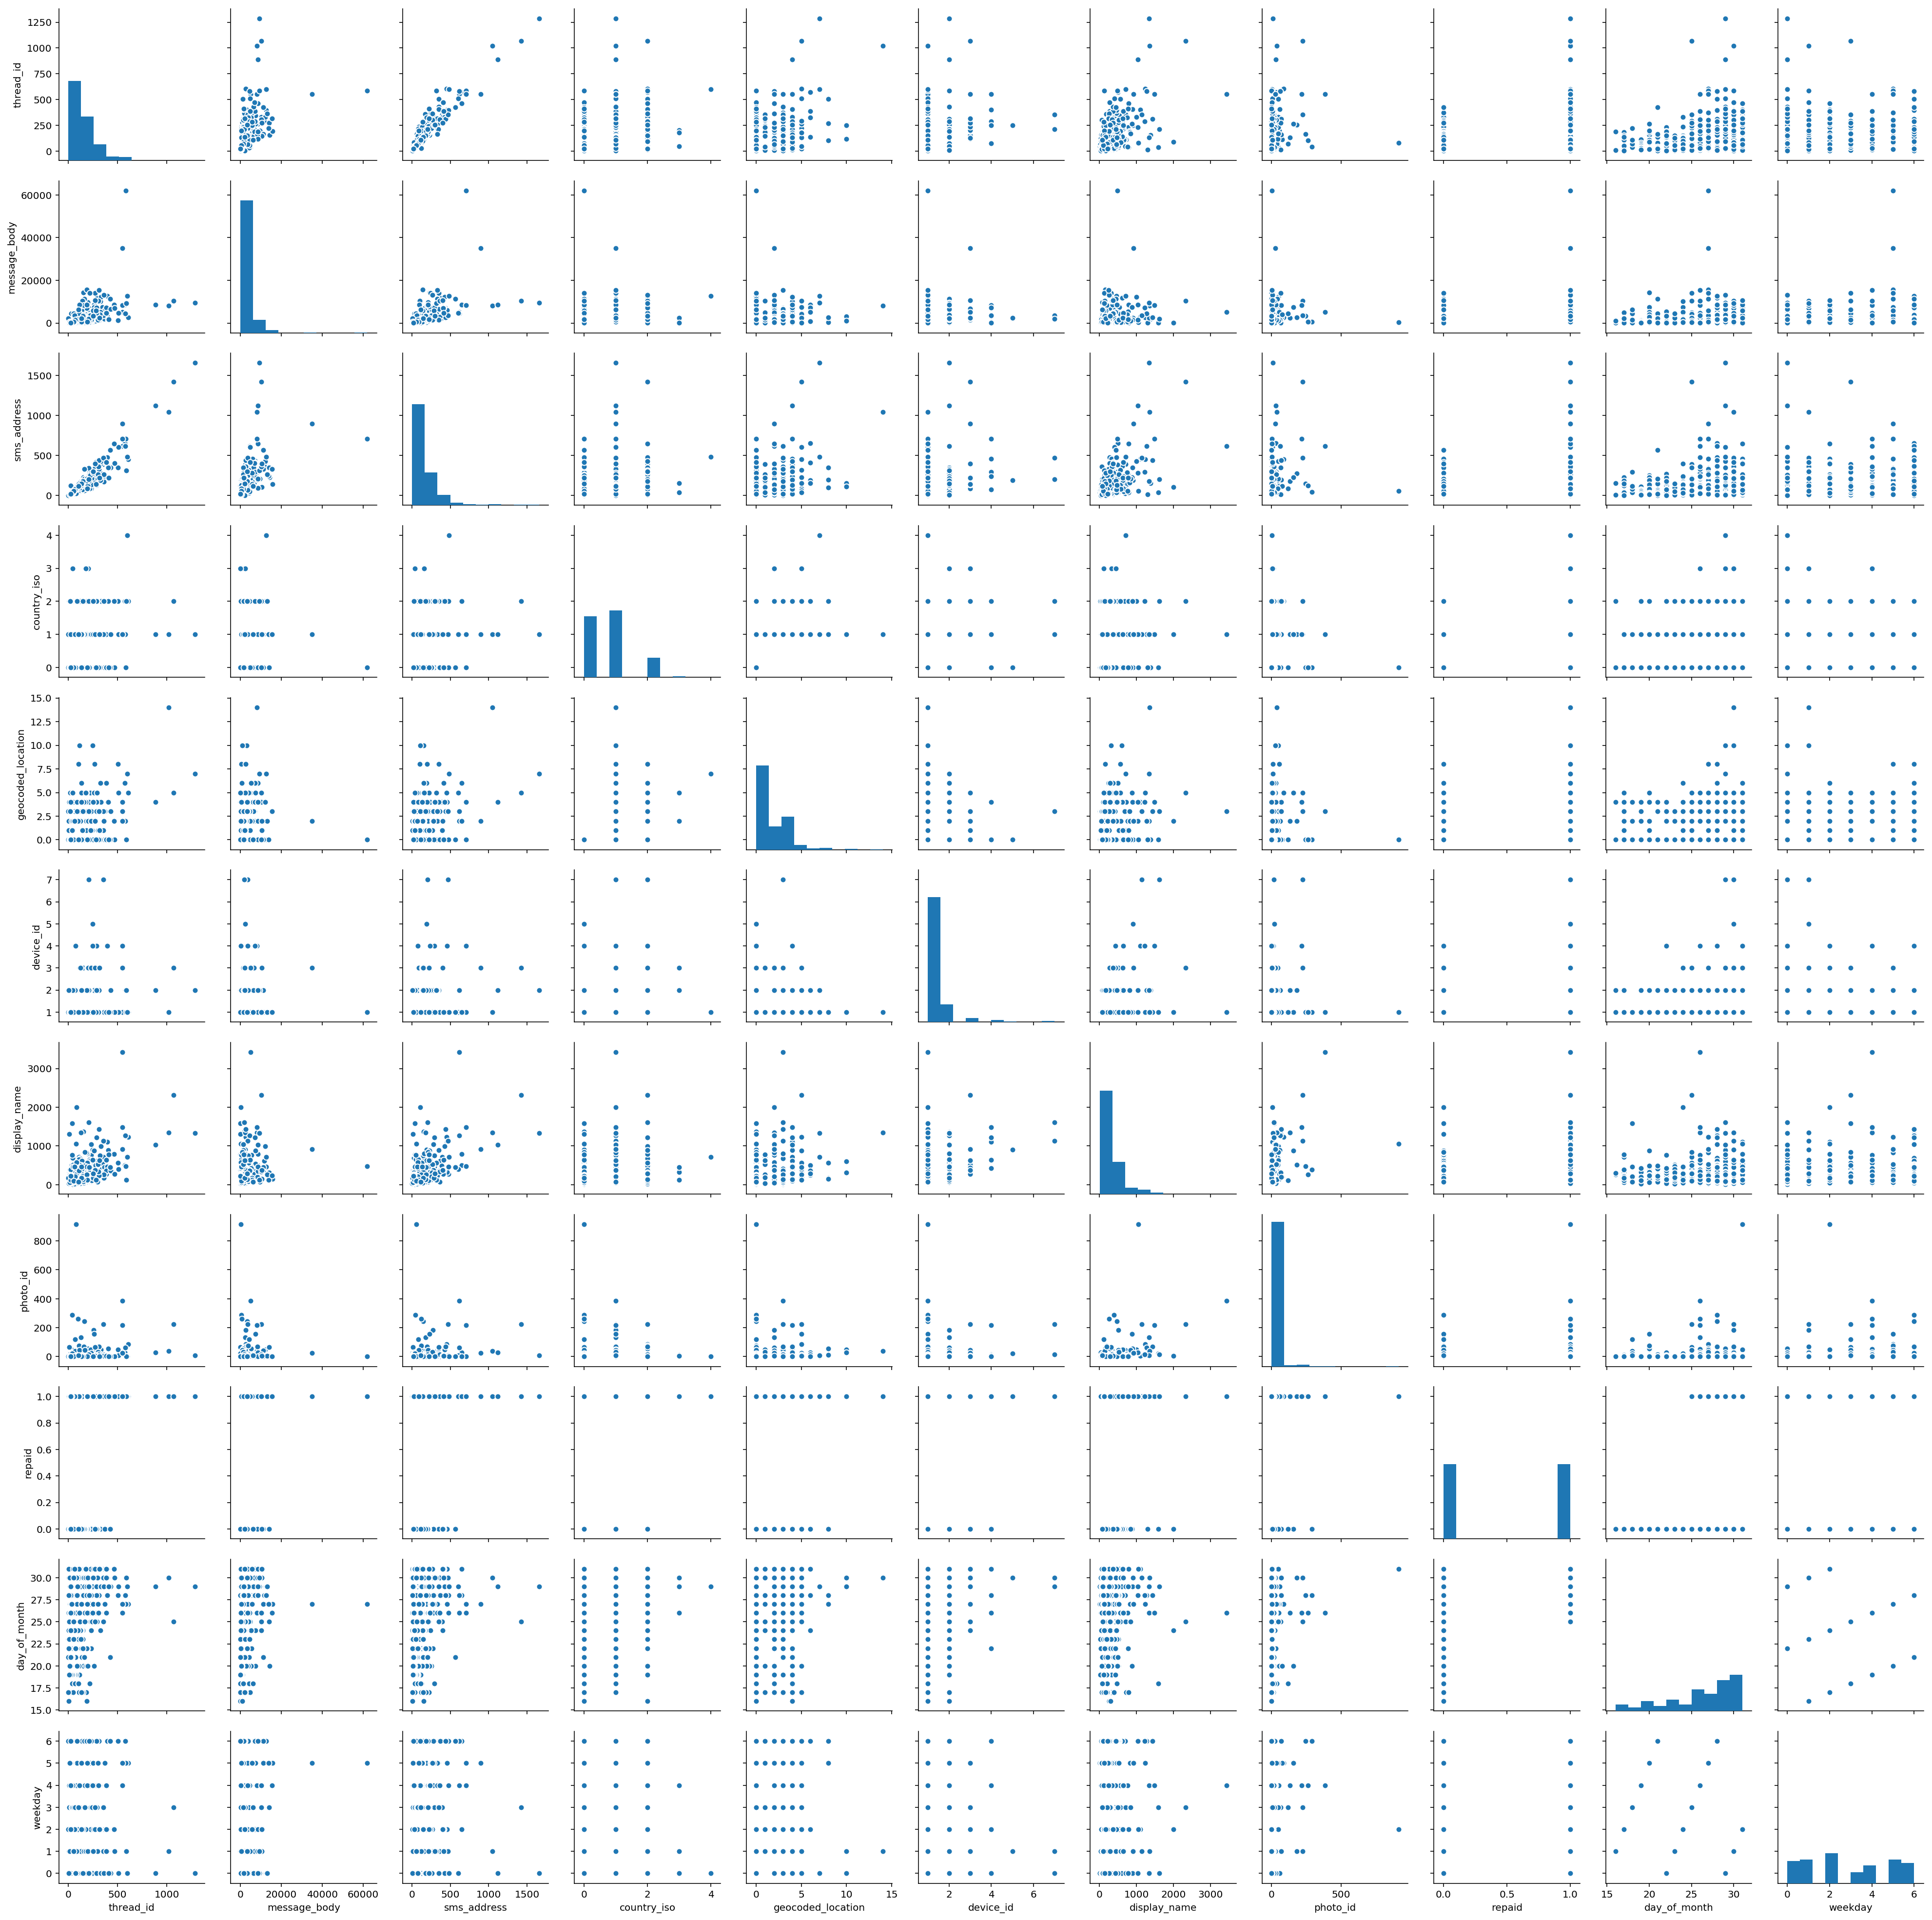

In [7]:
sns.pairplot(baseline_df)

# Throwing Models Around

In [8]:
# if the repaid column is 1 then they repaid, 0 if they defaulted
target = 'repaid'
variables = baseline_df.columns[baseline_df.columns != target]

x = baseline_df[variables]
y = baseline_df[target]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.33, random_state=42)

In [9]:
dt_gini = tree.DecisionTreeClassifier(max_depth=10)
dt_gini = dt_gini.fit(train_x,train_y)
y_pred = dt_gini.predict(test_x)
acc_gini = accuracy_score(test_y,y_pred)
print("Decision Tree (Gini) Accuracy = %3.2f" %(acc_gini))

Decision Tree (Gini) Accuracy = 0.69


In [10]:
dt_entropy = tree.DecisionTreeClassifier('entropy',max_depth=10)
dt_entropy = dt_entropy.fit(train_x,train_y)
y_pred = dt_entropy.predict(test_x)
acc_entropy = accuracy_score(test_y,y_pred)
print("Decision Tree (Entropy) Accuracy = %3.2f" %(acc_entropy))

Decision Tree (Entropy) Accuracy = 0.74


In [11]:
lr = linear_model.LogisticRegression()
lr = lr.fit(train_x,train_y)
y_pred = lr.predict(test_x)
acc_lr = accuracy_score(test_y, y_pred)
print("Logistic Regression Accuracy = %3.2f" %(acc_lr))

Logistic Regression Accuracy = 0.71


In [12]:
from sklearn.metrics import confusion_matrix
import itertools

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.72972973 0.27027027]
 [0.31034483 0.68965517]]


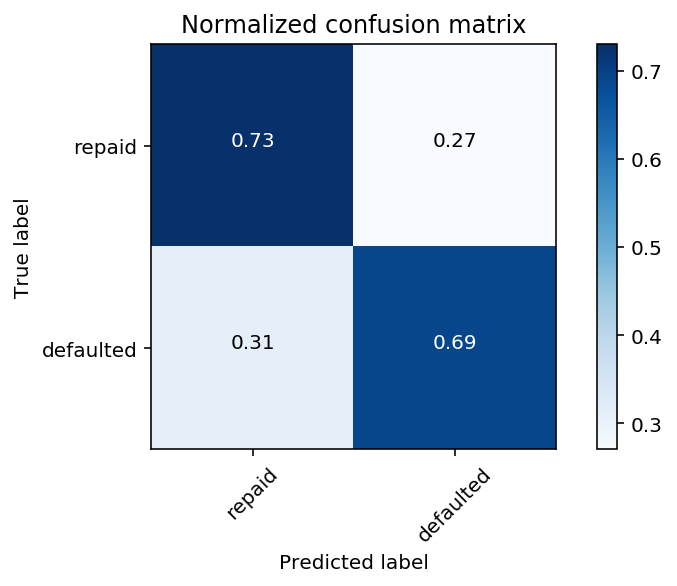

In [14]:
class_names = ['repaid', 'defaulted']

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

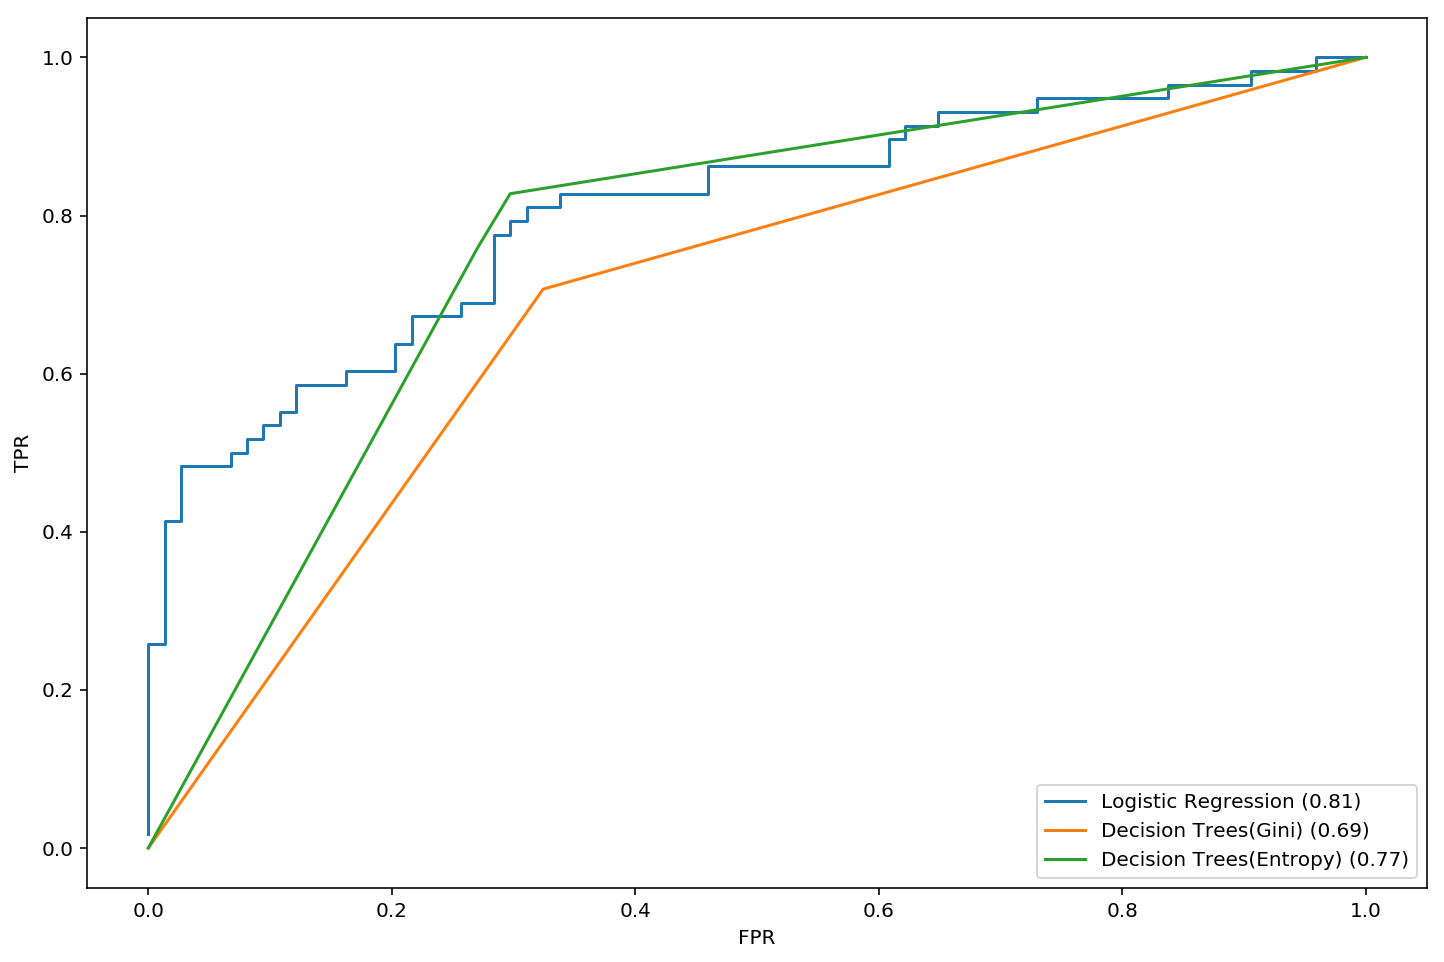

In [15]:
dt_gini_prob = dt_gini.predict_proba(test_x)
dt_entropy_prob = dt_entropy.predict_proba(test_x)
lr_prob = lr.predict_proba(test_x)

fpr_gini, tpr_gini, thresholds_gini = roc_curve(y_true=test_y, y_score = dt_gini_prob[:,1], pos_label=1)
fpr_entropy, tpr_entropy, thresholds_entropy = roc_curve(y_true=test_y, y_score = dt_entropy_prob[:,1], pos_label=1)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true=test_y, y_score = lr_prob[:,1], pos_label=1)

roc_auc_gini = roc_auc_score(y_true=test_y, y_score = dt_gini_prob[:,1])
roc_auc_entropy = roc_auc_score(y_true=test_y, y_score = dt_entropy_prob[:,1])
roc_auc_lr = roc_auc_score(y_true=test_y, y_score = lr_prob[:,1])

plt.figure(1, figsize=(12, 8));

plt.xlabel('FPR');
plt.ylabel('TPR');
plt.plot(fpr_lr,tpr_lr,label='Logistic Regression (%3.2f)'%roc_auc_lr)
plt.plot(fpr_gini,tpr_gini,label='Decision Trees(Gini) (%3.2f)'%roc_auc_gini)
plt.plot(fpr_entropy,tpr_entropy,label='Decision Trees(Entropy) (%3.2f)'%roc_auc_entropy)
plt.yticks(np.arange(0.0,1.01,.2))
plt.legend(loc='lower right')
plt.show();

In [16]:
# Set the random seed to be able to repeat the experiment
random_seed = 42 

In [17]:
models = {'Decision Tree':DecisionTreeClassifier(),
          'Bagging':BaggingClassifier(DecisionTreeClassifier()),
          'Random Forest':RandomForestClassifier(),
          'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier())}

In [18]:
folds = StratifiedKFold(n_splits=10,shuffle=True,random_state=random_seed)
scores = {}
for model_name in models:
    clf = models[model_name];
    score = cross_val_score(clf,x,y,cv=folds)
    scores[model_name]=(np.average(score),np.std(score))
    print('\t%26s\t%.3f +/- %.3f'%(model_name,scores[model_name][0],scores[model_name][1]))

	             Decision Tree	0.752 +/- 0.060
	                   Bagging	0.787 +/- 0.054
	             Random Forest	0.797 +/- 0.053
	                 Ada Boost	0.762 +/- 0.063


In [19]:
k = 10
knn_models = {'k-Nearest Neighbors':KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'),
          'Bagging':BaggingClassifier(KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'))}

In [20]:
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_seed)

scores = {}

for model_name in knn_models:
    clf = clone(knn_models[model_name]);
    score = cross_val_score(clf,x,y,cv=folds)
    scores[model_name]=(np.average(score),np.std(score))
    print('\t%26s\t%.3f +/- %.3f'%(model_name,scores[model_name][0],scores[model_name][1]))

	       k-Nearest Neighbors	0.622 +/- 0.053
	                   Bagging	0.618 +/- 0.056


In [21]:
estimators = [
        ('k-Nearest Neighbors', KNeighborsClassifier(n_neighbors=16, algorithm='kd_tree')), 
        ('Decision Tree', DecisionTreeClassifier(max_depth=None)), 
        ('Logistic Regression', LogisticRegression(random_state=random_seed)),
        ('Bagging', BaggingClassifier(DecisionTreeClassifier(max_depth=3))),
        ('Random Forest',RandomForestClassifier()),
        ('Ada Boost',AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)))
    ]

In [22]:
for (label,model) in estimators:
    scores = cross_val_score(clone(model), x, y, cv=folds, scoring='accuracy')
    print('\t%26s\t%.3f +/- %.3f'%(label,np.average(scores),np.std(scores)))

	       k-Nearest Neighbors	0.642 +/- 0.056
	             Decision Tree	0.777 +/- 0.023
	       Logistic Regression	0.780 +/- 0.062
	                   Bagging	0.802 +/- 0.025
	             Random Forest	0.785 +/- 0.015
	                 Ada Boost	0.785 +/- 0.027


In [ ]:
voting = VotingClassifier(estimators=estimators)
scores = cross_val_score(voting, x, y, cv=folds, scoring='accuracy')
print('\t%26s\t%.3f +/- %.3f'%('Voting',np.average(scores),np.std(scores)))

/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Mitchell/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
fitted = {}
for model_name in models:
    model = clone(models[model_name])
    score = model.fit(x,y)
    if(model_name != 'Bagging'):
        fitted[model_name] = (model,score,model.feature_importances_)

In [ ]:
plot_idx = 1
plt.figure(figsize=(10,20))
for model_name in fitted:
    plt.subplot(4,1,plot_idx)
    importances = fitted[model_name][2]
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances 
    plt.title("Feature importances - "+model_name)
    plt.xticks(range(x.shape[1]),x.columns[indices],rotation='vertical')
    
    plt.bar(range(x.shape[1]), importances[indices],align="center")
    plot_idx = plot_idx + 1

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None)
plt.show()

# Gridsearch through Hyperspace

In [ ]:
target = 'repaid'
variables = baseline_df.columns[baseline_df.columns!=target]

X, y = baseline_df[variables], baseline_df[target]

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_dist_r = {"max_depth": [3, None],
              "max_features": randint(1, 8),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

param_grid_g = {"max_depth": [3, None],
              "max_features": [1, 3, 8],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [ ]:
# Build a classifier
clf = RandomForestClassifier(n_estimators=20)

# Run Randomized Search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist_r,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

In [ ]:
# Run Grid Search
grid_search = GridSearchCV(clf, param_grid=param_grid_g)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)